# Forecasting Consensus Expectations: Consumer Price Index (CPI)
## Data Exploration

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.dates as mdates
import statsmodels.api as sm
import plotly.express as px

from tqdm.auto import tqdm
from scipy import stats, special
from scipy.optimize import brentq
from collections import defaultdict
from itertools import product
from scipy.stats import t as student_t, norm, binomtest, jarque_bera
from statsmodels.stats.diagnostic import het_breuschpagan

**Read**

In [3]:
OUT_DIR = "../out"        
MOM_DF_FILE       = "cpi_mom_df.parquet"
MOM_DF_FULL_FILE  = "cpi_mom_df_full.parquet"
YOY_DF_FILE       = "cpi_yoy_df.parquet"
YOY_DF_FULL_FILE  = "cpi_yoy_df_full.parquet"

mom_df       = pd.read_parquet(os.path.join(OUT_DIR, MOM_DF_FILE),      engine="pyarrow")
mom_df_full  = pd.read_parquet(os.path.join(OUT_DIR, MOM_DF_FULL_FILE), engine="pyarrow")

yoy_df       = pd.read_parquet(os.path.join(OUT_DIR, YOY_DF_FILE),      engine="pyarrow")
yoy_df_full  = pd.read_parquet(os.path.join(OUT_DIR, YOY_DF_FULL_FILE), engine="pyarrow")

print("mom_df shape     :", mom_df.shape)
print("mom_df_full shape:", mom_df_full.shape)

print("yoy_df shape     :", yoy_df.shape)
print("yoy_df_full shape:", yoy_df_full.shape)

mom_df shape     : (57710, 11)
mom_df_full shape: (68150, 11)
yoy_df shape     : (39400, 11)
yoy_df_full shape: (46492, 11)


In [4]:
mom_df.head()

,release_date,period,median_survey,actual,economist,firm,forecast,asof,error,surprise,series
0,2006-01-18,2005-12-31,0.2,0.2,Adam Chester,Lloyds Bank PLC,NaN,NaT,NaN,0.0,Core CPI M/M
1,2006-01-18,2005-12-31,0.2,0.2,Alessandro Truppia,Aletti Gestielle Sgr Spa,NaN,NaT,NaN,0.0,Core CPI M/M
2,2006-01-18,2005-12-31,0.2,0.2,Alison Lynn Reaser,Point Loma Nazarene University,0.2,2006-01-16,0.0,0.0,Core CPI M/M
3,2006-01-18,2005-12-31,0.2,0.2,Allan Von Mehren,Danske Bank AS,NaN,NaT,NaN,0.0,Core CPI M/M
4,2006-01-18,2005-12-31,0.2,0.2,Andreas Busch,Bantleon AG,0.2,2006-01-16,0.0,0.0,Core CPI M/M


In [5]:
mom_df_full.head()

,release_date,period,median_survey,actual,economist,firm,forecast,asof,error,surprise,series
0,2006-01-18,2005-12-31,0.2,0.2,Adam Chester,Lloyds Bank PLC,NaN,NaT,NaN,0.0,Core CPI M/M
1,2006-01-18,2005-12-31,0.2,0.2,Alessandro Truppia,Aletti Gestielle Sgr Spa,NaN,NaT,NaN,0.0,Core CPI M/M
2,2006-01-18,2005-12-31,0.2,0.2,Alison Lynn Reaser,Point Loma Nazarene University,0.2,2006-01-16,0.0,0.0,Core CPI M/M
3,2006-01-18,2005-12-31,0.2,0.2,Allan Von Mehren,Danske Bank AS,NaN,NaT,NaN,0.0,Core CPI M/M
4,2006-01-18,2005-12-31,0.2,0.2,Andreas Busch,Bantleon AG,0.2,2006-01-16,0.0,0.0,Core CPI M/M


In [6]:
yoy_df.head()

,release_date,period,median_survey,actual,economist,firm,forecast,asof,error,surprise,series
0,2006-01-18,2005-12-31,2.2,2.2,Adam Chester,Lloyds Bank PLC,NaN,NaT,NaN,0.0,Core CPI Y/Y
1,2006-01-18,2005-12-31,2.2,2.2,Allan Von Mehren,Danske Bank AS,NaN,NaT,NaN,0.0,Core CPI Y/Y
2,2006-01-18,2005-12-31,2.2,2.2,Andreas Busch,Bantleon AG,NaN,NaT,NaN,0.0,Core CPI Y/Y
3,2006-01-18,2005-12-31,2.2,2.2,Andrew Gretzinger,Manulife Asset Management Limited,NaN,NaT,NaN,0.0,Core CPI Y/Y
4,2006-01-18,2005-12-31,2.2,2.2,Aneta Markowska,Moore Capital Management LP,NaN,NaT,NaN,0.0,Core CPI Y/Y


In [7]:
yoy_df_full.head()

,release_date,period,median_survey,actual,economist,firm,forecast,asof,error,surprise,series
0,2006-01-18,2005-12-31,2.2,2.2,Adam Chester,Lloyds Bank PLC,NaN,NaT,NaN,0.0,Core CPI Y/Y
1,2006-01-18,2005-12-31,2.2,2.2,Allan Von Mehren,Danske Bank AS,NaN,NaT,NaN,0.0,Core CPI Y/Y
2,2006-01-18,2005-12-31,2.2,2.2,Andreas Busch,Bantleon AG,NaN,NaT,NaN,0.0,Core CPI Y/Y
3,2006-01-18,2005-12-31,2.2,2.2,Andrew Gretzinger,Manulife Asset Management Limited,NaN,NaT,NaN,0.0,Core CPI Y/Y
4,2006-01-18,2005-12-31,2.2,2.2,Aneta Markowska,Moore Capital Management LP,NaN,NaT,NaN,0.0,Core CPI Y/Y


**Explore**

In [10]:
plt.style.use("seaborn-v0_8-whitegrid")  
# -------------------------------------------------------------------------
# Helper: generate one-row-per-release table (median vs actual)
# -------------------------------------------------------------------------
def median_vs_actual(df_full: pd.DataFrame, window=6):
    tbl = (df_full.groupby("release_date")
                    .agg(crowd_median=("forecast", "median"),
                         actual      =("actual",   "first"))
                    .dropna()
                    .sort_index())
    tbl["err"] = tbl["crowd_median"] - tbl["actual"]
    tbl[f"rmse_{window}m"] = (tbl["err"]
                              .rolling(window, min_periods=window)
                              .apply(lambda x: np.sqrt(np.mean(x**2)),
                                     raw=True))
    return tbl

# -------------------------------------------------------------------------
# Helper: distribution diagnostics (hist + QQ + normality tests)
# -------------------------------------------------------------------------
def dist_diagnostics(errors: np.ndarray, title_prefix=""):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    sns.histplot(errors, bins=50, edgecolor="k", ax=axs[0])
    axs[0].set_title(f"{title_prefix}Error histogram")
    axs[0].set_xlabel("Error"); axs[0].set_ylabel("Freq")

    # --- FIXED: give a distribution object, not a string --------------
    sm.qqplot(errors, dist=stats.norm, line="s", ax=axs[1])
    axs[1].set_title(f"{title_prefix}QQ-plot vs Normal")

    plt.tight_layout(); plt.show()

    jb_stat, jb_p = st.jarque_bera(errors)
    nu, loc, scale = st.t.fit(errors)
    ks_stat, ks_p  = st.kstest(errors, "t", args=(nu, loc, scale))

    print(f"{title_prefix}Jarque-Bera   : JB = {jb_stat:,.1f}, p = {jb_p:.4f}")
    print(f"{title_prefix}Student-t fit : ν = {nu:4.1f}, "
          f"KS p-value = {ks_p:.4f}\n")


# -------------------------------------------------------------------------
# Helper: cross-section spread vs |median error|
# -------------------------------------------------------------------------
def spread_vs_error(df_panel: pd.DataFrame, label=""):
    spread = (df_panel.groupby("release_date")["forecast"].std(ddof=0)
                        .rename("spread"))
    med_err = (df_panel.groupby("release_date")
                          .apply(lambda d: 
                                 (d["median_survey"].iloc[0] - d["actual"].iloc[0]))
                          .rename("median_err").abs())
    tbl = pd.concat([spread, med_err], axis=1).dropna()

    sns.regplot(data=tbl, x="spread", y="median_err", scatter_kws={"alpha":0.6})
    plt.title(f"Cross-section spread vs |Median error| ({label})")
    plt.xlabel("Forecast SD"); plt.ylabel("|Median error|")
    plt.tight_layout(); plt.show()

    pearson = tbl.corr(method="pearson").loc["spread","median_err"]
    spearman = tbl.corr(method="spearman").loc["spread","median_err"]
    print(f"{label} ρ_Pearson  = {pearson:6.3f}")
    print(f"{label} ρ_Spearman = {spearman:6.3f}\n")

# -------------------------------------------------------------------------
# Helper: active economist count with contiguity rule
# -------------------------------------------------------------------------
def active_economists(df_full: pd.DataFrame, windows=(6,12,24)):
    dates = np.sort(df_full["release_date"].unique())
    active = {}

    for W in windows:
        counts = []
        for i in range(W, len(dates)):
            slc = df_full[df_full["release_date"].isin(dates[i-W:i])]
            ok  = slc.groupby("economist")["forecast"].apply(lambda s: s.notna().all())
            counts.append((dates[i], ok.sum()))
        active[W] = pd.Series({d:c for d,c in counts})

    plt.figure(figsize=(10,4))
    for W, s in active.items():
        plt.plot(s.index, s.values, marker="o", label=f"{W}-mo")
    plt.title("Active economists per release (contiguity filter)")
    plt.xlabel("Release date"); plt.ylabel("# Economists")
    plt.legend(); plt.tight_layout(); plt.show()



========== Core CPI M/M ==========


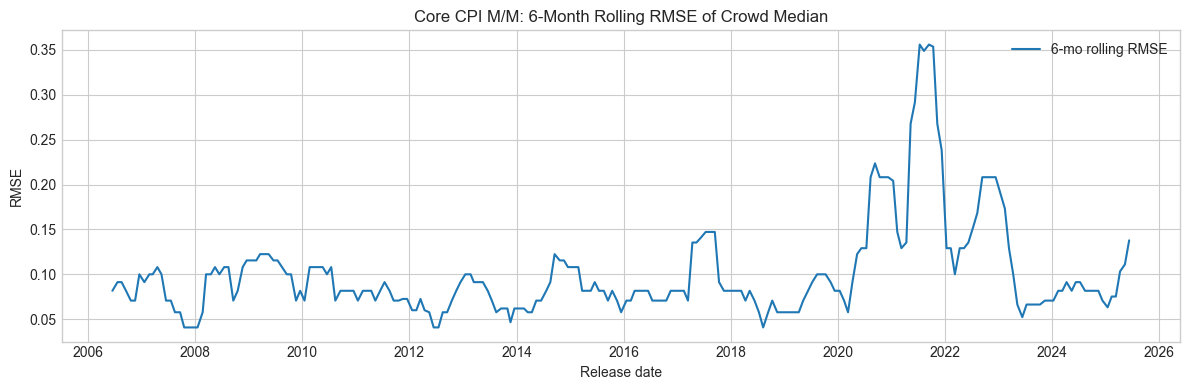

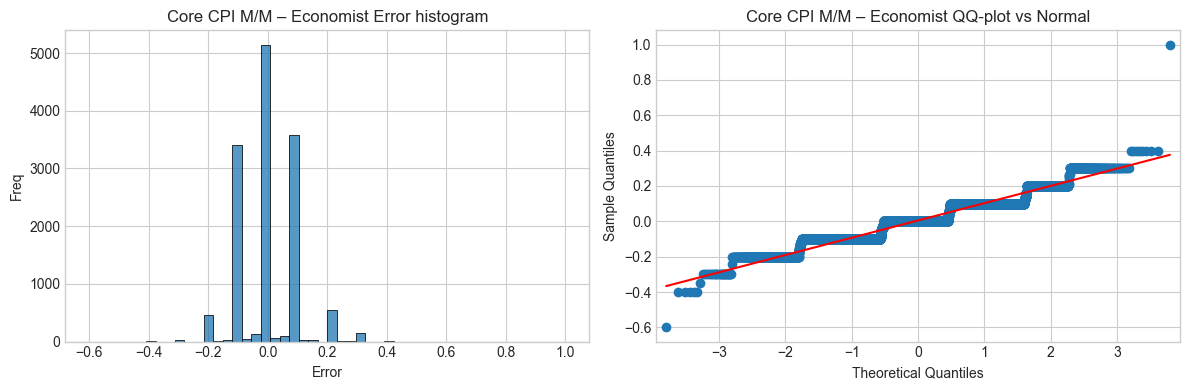

Core CPI M/M – Economist Jarque-Bera   : JB = 807.3, p = 0.0000
Core CPI M/M – Economist Student-t fit : ν = 23.0, KS p-value = 0.0000



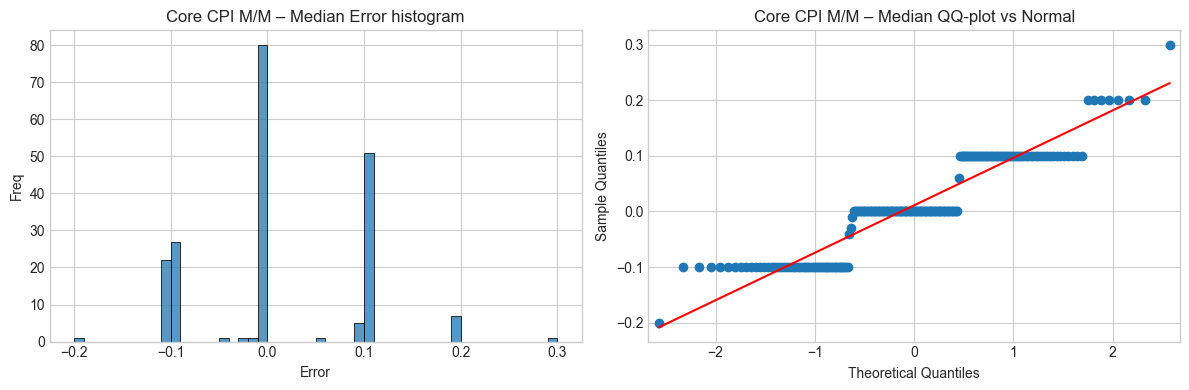

Core CPI M/M – Median Jarque-Bera   : JB = 3.1, p = 0.2145
Core CPI M/M – Median Student-t fit : ν = 197167490.7, KS p-value = 0.0000



C:\Users\nwong\AppData\Local\Temp\ipykernel_22952\2017207694.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d:


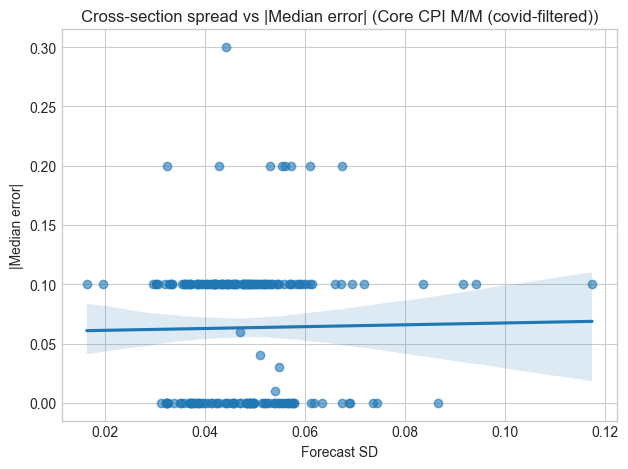

Core CPI M/M (covid-filtered) ρ_Pearson  =  0.017
Core CPI M/M (covid-filtered) ρ_Spearman =  0.017



C:\Users\nwong\AppData\Local\Temp\ipykernel_22952\2017207694.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d:


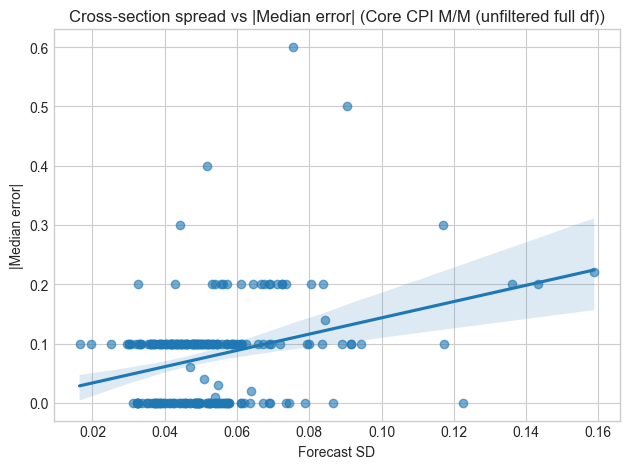

Core CPI M/M (unfiltered full df) ρ_Pearson  =  0.317
Core CPI M/M (unfiltered full df) ρ_Spearman =  0.209



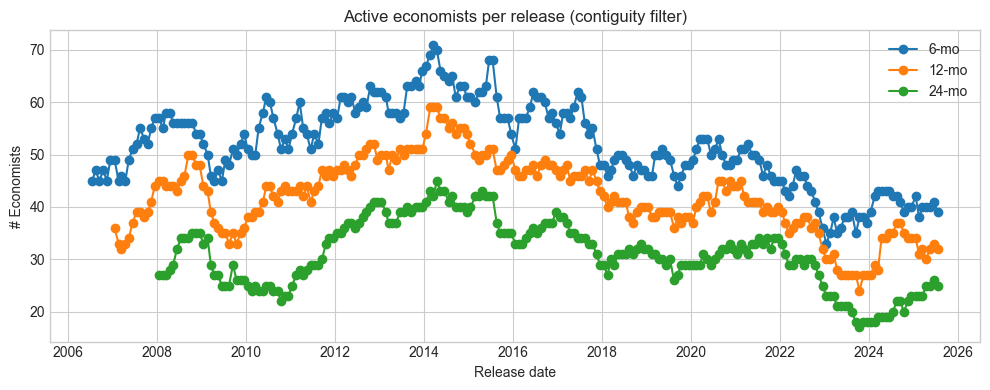


========== Core CPI Y/Y ==========


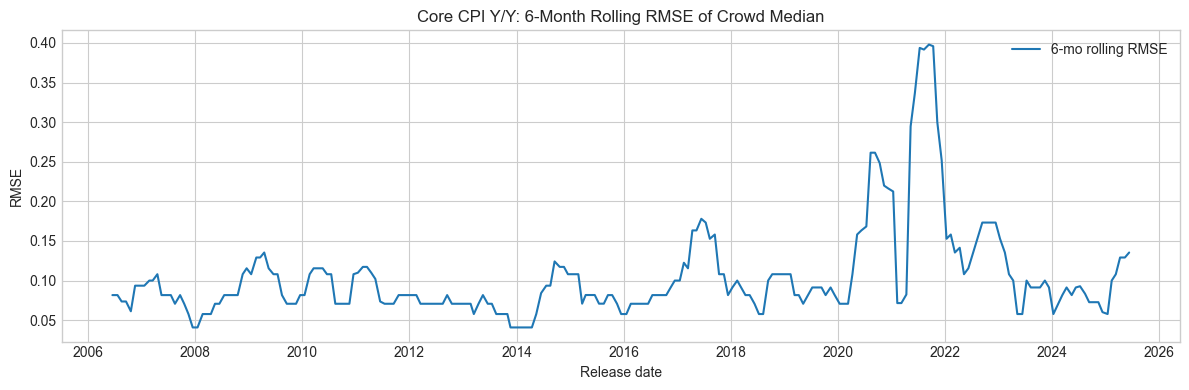

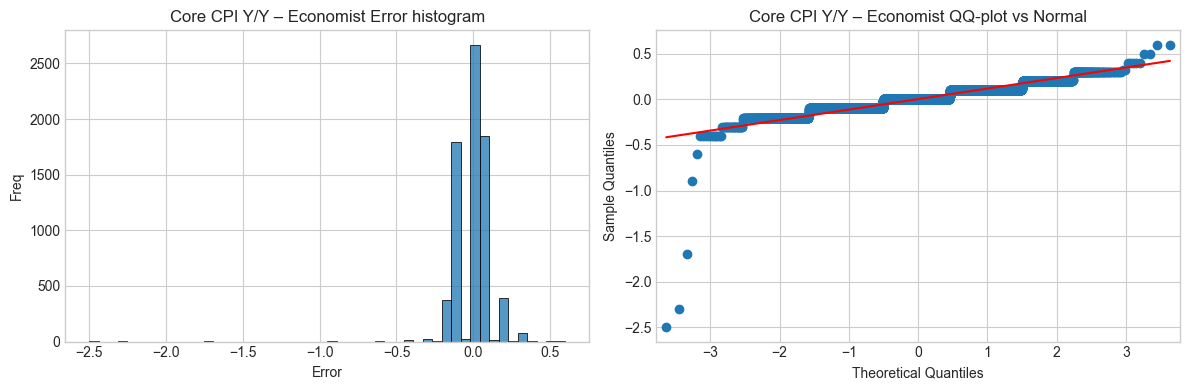

Core CPI Y/Y – Economist Jarque-Bera   : JB = 1,090,102.3, p = 0.0000
Core CPI Y/Y – Economist Student-t fit : ν = 10.0, KS p-value = 0.0000



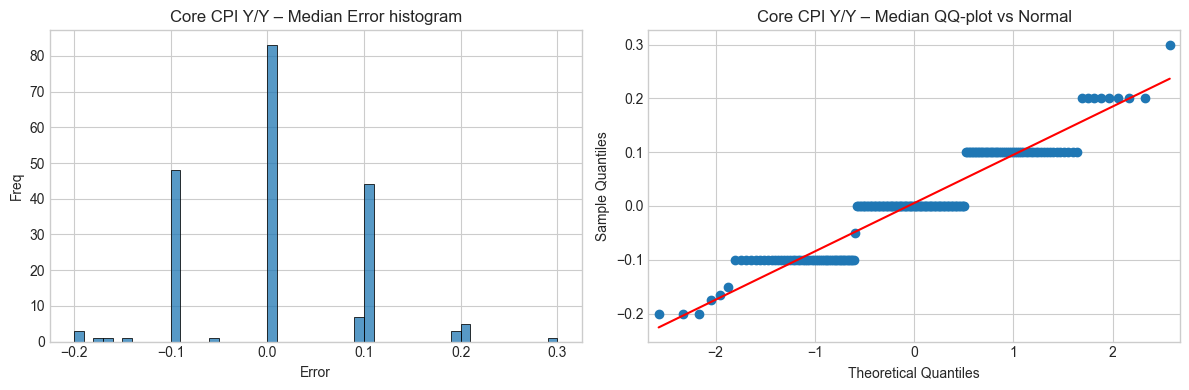

Core CPI Y/Y – Median Jarque-Bera   : JB = 1.7, p = 0.4295
Core CPI Y/Y – Median Student-t fit : ν = 25966373375.8, KS p-value = 0.0000



C:\Users\nwong\AppData\Local\Temp\ipykernel_22952\2017207694.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d:


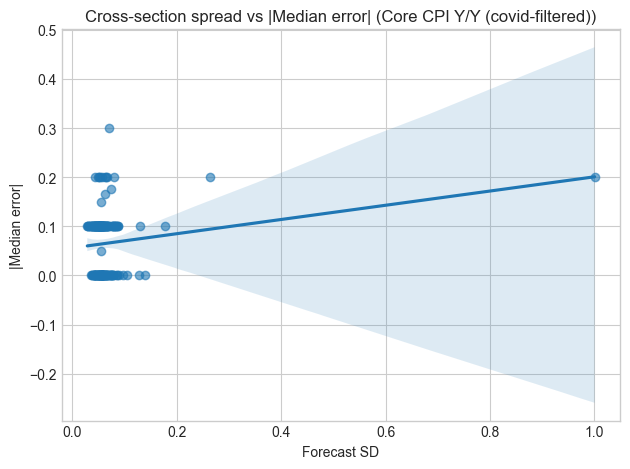

Core CPI Y/Y (covid-filtered) ρ_Pearson  =  0.166
Core CPI Y/Y (covid-filtered) ρ_Spearman = -0.031



C:\Users\nwong\AppData\Local\Temp\ipykernel_22952\2017207694.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d:


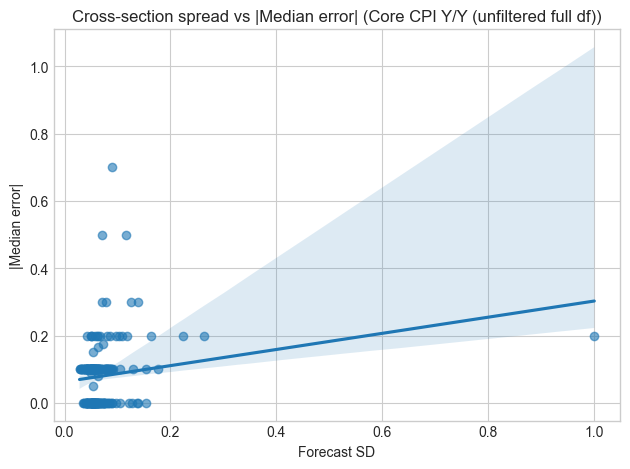

Core CPI Y/Y (unfiltered full df) ρ_Pearson  =  0.183
Core CPI Y/Y (unfiltered full df) ρ_Spearman =  0.090



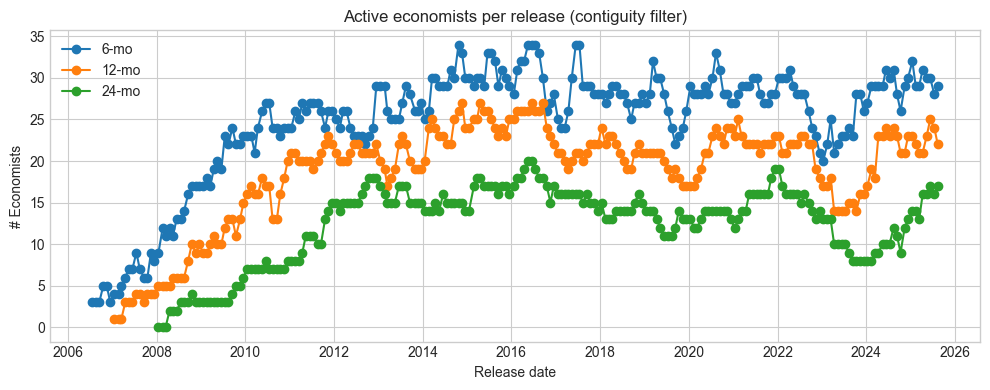

In [ ]:
PANELS = {
    "Core CPI M/M": {"df": mom_df, "df_full": mom_df_full},
    "Core CPI Y/Y": {"df": yoy_df, "df_full": yoy_df_full},
}

for name, d in PANELS.items():
    print(f"\n========== {name} ==========")

    df, df_full = d["df"], d["df_full"]

    # 1. Rolling RMSE of crowd median
    mv_tbl = median_vs_actual(df_full, window=6)
    plt.figure(figsize=(12,4))
    plt.plot(mv_tbl.index, mv_tbl["rmse_6m"], label="6-mo rolling RMSE")
    plt.title(f"{name}: 6-Month Rolling RMSE of Crowd Median")
    plt.xlabel("Release date"); plt.ylabel("RMSE"); plt.legend(); plt.tight_layout(); plt.show()

    # 2. Economist-level error diagnostics
    errors_econ = df["error"].dropna().values
    dist_diagnostics(errors_econ, title_prefix=f"{name} – Economist ")

    # 3. Median-forecast error diagnostics
    med_errors = (df
                  .drop_duplicates("release_date")
                  .assign(med_err=lambda d: d["median_survey"] - d["actual"])
                  ["med_err"].dropna().values)
    dist_diagnostics(med_errors, title_prefix=f"{name} – Median ")

    # 4. Cross-section spread vs |median error|
    spread_vs_error(df, label=name)

    # 5. Active forecaster counts
    active_economists(df_full)

- Filter to 2010+: post-GFC regime, enough economists (YoY) pass contiguity filter